In [1]:
import pandas as pd
import shap 

In [2]:
# import dask 
from dask.distributed import Client, progress
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.0.80.197:8787/status,
Dashboard: http://10.0.80.197:8787/status,Workers: 1
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: False
Comm: inproc://10.0.80.197/1567/1,Workers: 1
Dashboard: http://10.0.80.197:8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: inproc://10.0.80.197/1567/4,Total threads: 4
Dashboard: http://10.0.80.197:35731/status,Memory: 1.86 GiB
Nanny: None,


In [3]:
data = pd.read_csv("votedmetadata_streamcat_sed.csv")

data

,ID,WsAreaSqKm,CatAreaSqKm,ElevCat,CatPctFull,WsPctFull,PctAg2006Slp10Cat,PctAg2006Slp10Ws,PctAg2006Slp20Cat,PctAg2006Slp20Ws,...,Primary.Sources.Flow.Variation,resprate_mg.L.h,Sediment_Bedrock,Stream_Order,Sunlight.Access_Perc.Canopy.Cover,Water.Column.Height_cm,altS,MAT,MAP,cluster
0,SED_S19S.0001_D_Field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.00,1,9,1,17.00,35,9.9,1770,sed_2
1,SED_S19S.0001_M_Field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.00,1,9,1,16.00,35,9.9,1770,sed_2
2,SED_S19S.0001_U_Field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.00,1,9,1,19.00,347,8.7,299,sed_2
3,SED_S19S.0003_D_Field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.00,2,7,1,35.00,347,8.7,299,sed_2
4,SED_S19S.0003_M_Field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1.00,2,7,1,30.00,347,8.7,299,sed_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,SED_S19S.0099_M_Field,9920.0,2.43,184.0,100.0,100.0,3.37,0.79,0.15,0.03,...,2,2.77,3,7,1,19.20,947,9.7,438,sed_0
235,SED_S19S.0099_U_Field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,1.36,3,7,1,20.47,947,9.7,438,sed_2
236,SED_S19S.0100_D_Field,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18,12.08,3,2,1,18.00,1753,7.7,640,sed_2
237,SED_S19S.0100_M_Field,86.7,17.10,2990.0,100.0,100.0,0.00,0.00,0.00,0.00,...,18,2.67,3,2,1,34.00,1753,7.7,640,sed_2


In [4]:
# print all column titles 
data.columns

Index(['ID', 'WsAreaSqKm', 'CatAreaSqKm', 'ElevCat', 'CatPctFull', 'WsPctFull',
       'PctAg2006Slp10Cat', 'PctAg2006Slp10Ws', 'PctAg2006Slp20Cat',
       'PctAg2006Slp20Ws',
       ...
       'Primary.Sources.Flow.Variation', 'resprate_mg.L.h', 'Sediment_Bedrock',
       'Stream_Order', 'Sunlight.Access_Perc.Canopy.Cover',
       'Water.Column.Height_cm', 'altS', 'MAT', 'MAP', 'cluster'],
      dtype='object', length=428)

In [5]:
# check all the nans

print("No. of columns containing null values")
print(len(data.columns[data.isna().any()]))

print("No. of columns not containing null values")
print(len(data.columns[data.notna().all()]))

print("Total no. of columns in the dataframe")
print(len(data.columns))

No. of columns containing null values
401
No. of columns not containing null values
27
Total no. of columns in the dataframe
428


In [6]:
import numpy as np 
# drop parameters with low importance. For sediment its only top 15 parameters 

data2 = data[['NPOC_mg.L.asC', 'resprate_mg.L.h', 'del18O_permil', 'MAT', 
              'MAP', 'del2H_permil', 'F_mgL', 'altS', 'PctGrs2001WsRp100', 'General_Vegetation',
              'Water.Column.Height_cm', 'NO3_mgL', 'WsAreaSqKmSlp20', 'Sunlight.Access_Perc.Canopy.Cover', 
              'PctHbWet2001Ws', 'cluster']]

data2

,NPOC_mg.L.asC,resprate_mg.L.h,del18O_permil,MAT,MAP,del2H_permil,F_mgL,altS,PctGrs2001WsRp100,General_Vegetation,Water.Column.Height_cm,NO3_mgL,WsAreaSqKmSlp20,Sunlight.Access_Perc.Canopy.Cover,PctHbWet2001Ws,cluster
0,2.35,1.00,1.00,9.9,1770,1.0,1.00,35,NaN,1,17.00,1.00,NaN,1,NaN,sed_2
1,2.50,1.00,1.00,9.9,1770,1.0,1.00,35,NaN,1,16.00,1.00,NaN,1,NaN,sed_2
2,3.17,1.00,1.00,8.7,299,1.0,1.00,347,NaN,1,19.00,1.00,NaN,1,NaN,sed_2
3,17.21,1.00,-18.75,8.7,299,1.0,0.07,347,NaN,0,35.00,0.19,NaN,1,NaN,sed_2
4,30.92,1.00,-18.75,8.7,299,1.0,0.07,347,NaN,0,30.00,0.19,NaN,1,NaN,sed_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,14.18,2.77,-16.08,9.7,438,-122.8,0.33,947,0.75,6,19.20,4.43,47.0,1,0.22,sed_0
235,6.77,1.36,-16.08,9.7,438,-122.8,0.33,947,NaN,6,20.47,4.43,NaN,1,NaN,sed_2
236,12.65,12.08,-6.53,7.7,640,-43.3,0.09,1753,NaN,2,18.00,0.12,NaN,1,NaN,sed_2
237,5.51,2.67,-6.53,7.7,640,-43.3,0.09,1753,5.47,2,34.00,0.12,69.5,1,2.16,sed_2


In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data2, test_size=0.20, random_state=42)
train # just display the train set for now. 

,NPOC_mg.L.asC,resprate_mg.L.h,del18O_permil,MAT,MAP,del2H_permil,F_mgL,altS,PctGrs2001WsRp100,General_Vegetation,Water.Column.Height_cm,NO3_mgL,WsAreaSqKmSlp20,Sunlight.Access_Perc.Canopy.Cover,PctHbWet2001Ws,cluster
138,18.17,1.00,-6.83,7.1,1052,-34.1,0.09,417,NaN,18,68.00,7.05,NaN,1,NaN,sed_2
60,9.26,1.85,-17.17,16.2,1008,-125.8,0.04,297,NaN,13,17.00,0.12,NaN,3,NaN,sed_2
207,16.71,2.35,-15.83,11.8,176,-121.1,0.38,116,4.46,3,8.25,0.12,769.000,3,0.08,sed_0
165,7.01,1.00,-10.86,7.6,811,-73.1,0.03,280,0.19,13,3.00,0.13,53.700,4,0.00,sed_2
206,17.21,1.34,-15.83,11.8,176,-121.1,0.38,115,NaN,3,8.50,0.12,NaN,2,NaN,sed_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,17.05,1.00,-3.68,12.1,865,-20.9,0.05,370,0.03,11,22.00,0.40,0.000,1,0.10,sed_2
14,20.73,0.99,-2.90,7.2,854,-13.4,0.11,2144,NaN,5,30.00,0.85,NaN,1,NaN,sed_0
92,12.78,3.70,-3.80,16.9,478,-18.6,0.16,1334,NaN,6,7.60,7.82,NaN,2,NaN,sed_2
179,20.24,1.00,-6.18,13.4,221,-42.2,0.03,1524,NaN,3,7.00,0.55,NaN,4,NaN,sed_2


In [8]:
# Drop the target column, that is the "cluster" column. 
# 1. Train data first. 
# Create X_train input and y_train for output (target) by dropping columns. 

X_train = train.drop(['cluster'], axis=1)

y_train = train["cluster"] 

X_train

,NPOC_mg.L.asC,resprate_mg.L.h,del18O_permil,MAT,MAP,del2H_permil,F_mgL,altS,PctGrs2001WsRp100,General_Vegetation,Water.Column.Height_cm,NO3_mgL,WsAreaSqKmSlp20,Sunlight.Access_Perc.Canopy.Cover,PctHbWet2001Ws
138,18.17,1.00,-6.83,7.1,1052,-34.1,0.09,417,NaN,18,68.00,7.05,NaN,1,NaN
60,9.26,1.85,-17.17,16.2,1008,-125.8,0.04,297,NaN,13,17.00,0.12,NaN,3,NaN
207,16.71,2.35,-15.83,11.8,176,-121.1,0.38,116,4.46,3,8.25,0.12,769.000,3,0.08
165,7.01,1.00,-10.86,7.6,811,-73.1,0.03,280,0.19,13,3.00,0.13,53.700,4,0.00
206,17.21,1.34,-15.83,11.8,176,-121.1,0.38,115,NaN,3,8.50,0.12,NaN,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,17.05,1.00,-3.68,12.1,865,-20.9,0.05,370,0.03,11,22.00,0.40,0.000,1,0.10
14,20.73,0.99,-2.90,7.2,854,-13.4,0.11,2144,NaN,5,30.00,0.85,NaN,1,NaN
92,12.78,3.70,-3.80,16.9,478,-18.6,0.16,1334,NaN,6,7.60,7.82,NaN,2,NaN
179,20.24,1.00,-6.18,13.4,221,-42.2,0.03,1524,NaN,3,7.00,0.55,NaN,4,NaN


In [9]:
y_train

138    sed_2
60     sed_2
207    sed_0
165    sed_2
206    sed_0
       ...  
106    sed_2
14     sed_0
92     sed_2
179    sed_2
102    sed_0
Name: cluster, Length: 191, dtype: object

In [10]:
# 2. Test dataset
X_test = test.drop(['cluster'], axis=1)

y_test = test["cluster"] 

X_test.head(10) # print only 10 

,NPOC_mg.L.asC,resprate_mg.L.h,del18O_permil,MAT,MAP,del2H_permil,F_mgL,altS,PctGrs2001WsRp100,General_Vegetation,Water.Column.Height_cm,NO3_mgL,WsAreaSqKmSlp20,Sunlight.Access_Perc.Canopy.Cover,PctHbWet2001Ws
24,16.73,1.00,-7.98,7.4,1166,-47.5,0.06,233,NaN,8,3.0,0.97,NaN,4,NaN
6,18.34,1.00,-17.13,7.7,449,-129.3,0.07,346,NaN,1,19.0,0.12,NaN,1,NaN
93,12.11,32.74,-3.80,12.0,184,-18.6,0.16,112,92.60,6,20.0,7.82,0.2720,2,0.00
109,2.70,1.00,1.00,8.5,246,1.0,1.00,871,NaN,17,10.0,1.00,NaN,1,NaN
104,8.22,1.00,-8.45,14.0,1348,-55.0,0.10,239,NaN,2,45.0,50.69,NaN,1,NaN
172,5.62,1.04,-6.21,10.1,968,-38.1,0.06,227,0.00,15,4.0,0.12,3.2300,2,0.00
200,22.25,27.96,-4.90,9.1,1148,-32.4,0.02,19,NaN,1,60.0,0.12,NaN,1,NaN
86,16.06,2.37,-7.24,12.6,812,-42.3,0.05,1195,0.06,1,15.9,18.17,0.0504,1,0.26
9,9.24,15.22,1.00,12.5,1118,1.0,0.02,115,NaN,3,17.0,6.43,NaN,1,NaN
142,10.74,5.24,-12.76,9.6,1172,-96.9,0.15,48,18.00,6,34.0,5.69,5780.0000,3,0.57


In [11]:
from sklearn.ensemble import HistGradientBoostingClassifier


# 1. Baseline model development: 
Run SHAP on both the test and train data 

In [12]:
import time
import joblib

import numpy as np
#from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

start = time.time()
#classifier = RandomForestClassifier()
classifier = HistGradientBoostingClassifier() # this can handle NaNs

#rf_fitted = classifier.fit(X_train, y_train)
gb_fitted = classifier.fit(X_train, y_train) 

scores = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10, n_jobs=-1)

print("training time taken: ", round(time.time() - start, 0), "seconds")
print("CV accuracy scores: %s" % scores)
print("CV accuracy:%.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

training time taken:  2.0 seconds
CV accuracy scores: [0.65       0.73684211 0.84210526 0.78947368 0.63157895 0.57894737
 0.78947368 0.63157895 0.78947368 0.68421053]
CV accuracy:0.712 +/- 0.084


In [13]:
#train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(), X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1, 10))
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=classifier, 
                                                        X=X_train, y=y_train, cv=10, n_jobs=-1, random_state=42,
                                                        scoring='accuracy', train_sizes=np.linspace(0.1, 1, 10))

In [14]:
# get data to plot the learning curve 
from sklearn.model_selection import learning_curve

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

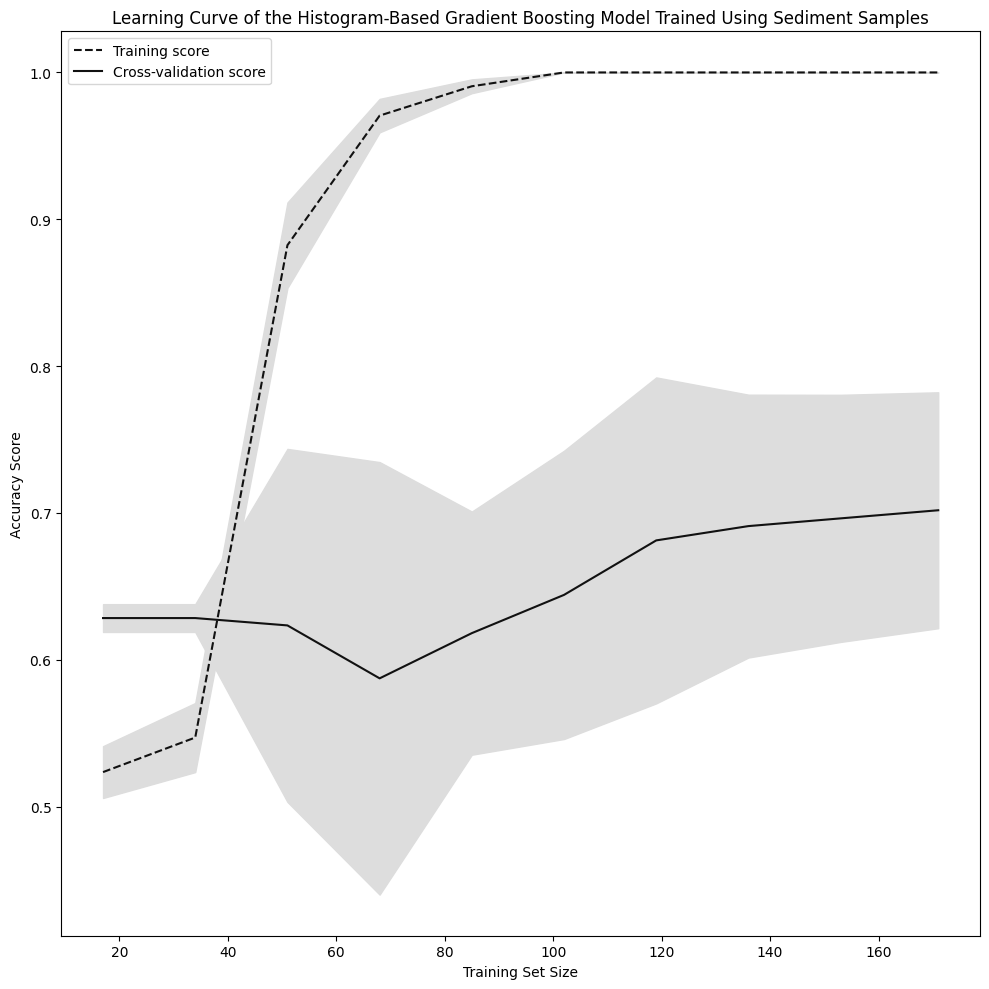

In [15]:
# plot the learning curve 
from matplotlib import pyplot as plt
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve of the Histogram-Based Gradient Boosting Model Trained Using Sediment Samples")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig("learningcurveGB_sed_baselineV2.jpg") # prelim interpretation: model overfit; maybe tune the model

In [16]:
test_pred = classifier.predict(X_test)

test_pred

array(['sed_2', 'sed_2', 'sed_2', 'sed_2', 'sed_2', 'sed_2', 'sed_2',
       'sed_2', 'sed_2', 'sed_2', 'sed_2', 'sed_2', 'sed_2', 'sed_2',
       'sed_2', 'sed_0', 'sed_2', 'sed_0', 'sed_2', 'sed_2', 'sed_2',
       'sed_2', 'sed_0', 'sed_2', 'sed_2', 'sed_2', 'sed_0', 'sed_2',
       'sed_2', 'sed_0', 'sed_2', 'sed_2', 'sed_2', 'sed_2', 'sed_0',
       'sed_2', 'sed_1', 'sed_1', 'sed_2', 'sed_2', 'sed_2', 'sed_0',
       'sed_2', 'sed_2', 'sed_0', 'sed_0', 'sed_0', 'sed_0'], dtype=object)

In [17]:
# get the accuracy score and confusion matrix from the test set. 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(y_test, test_pred)

0.6041666666666666

In [18]:
print(f"RF train accuracy: {gb_fitted.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {gb_fitted.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.604


In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
report = classification_report(y_test, test_pred, output_dict=True)
report2 = classification_report(y_test, test_pred)
print(report2) 

# export the csv file 
df = pd.DataFrame(report).transpose()
df.to_csv('classreportGB_sed_baselineV2.csv')

              precision    recall  f1-score   support

       sed_0       0.55      0.30      0.39        20
       sed_1       0.50      0.50      0.50         2
       sed_2       0.63      0.85      0.72        26

    accuracy                           0.60        48
   macro avg       0.56      0.55      0.54        48
weighted avg       0.59      0.60      0.57        48



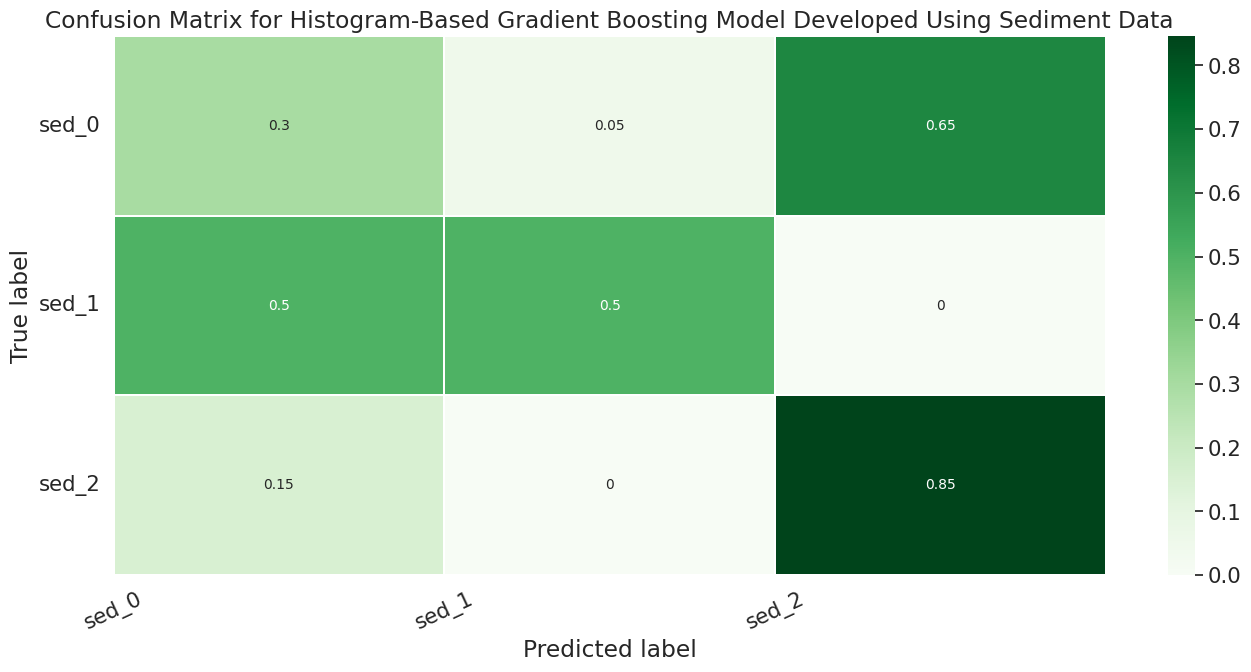

In [20]:
import seaborn as sns
matrix = confusion_matrix(y_test, test_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['sed_0', 'sed_1', 'sed_2']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Histogram-Based Gradient Boosting Model Developed Using Sediment Data')
#plt.show() 
plt.savefig("confusionmatrixGB_sed_baselineV2.jpg", dpi=500, bbox_inches='tight')

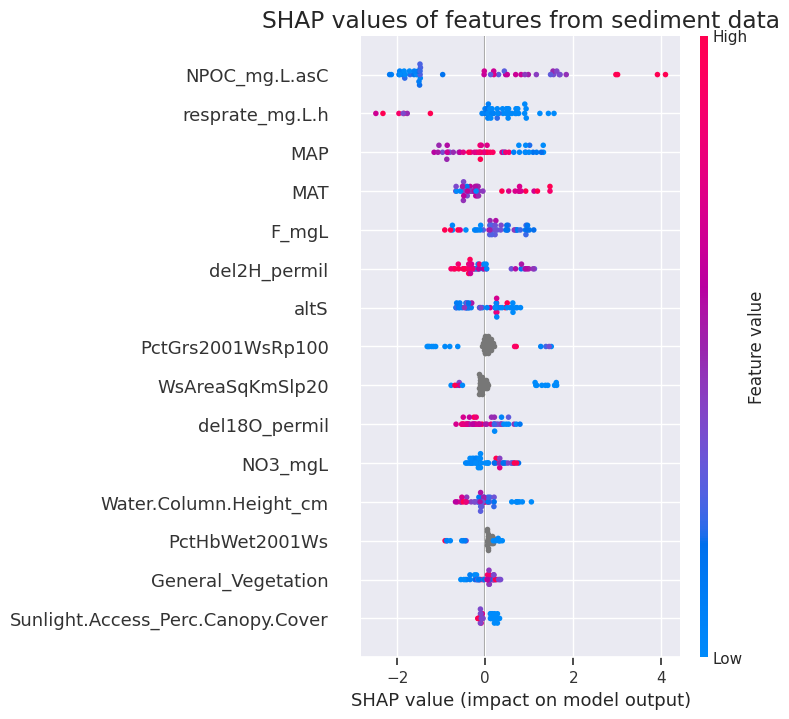

In [21]:
# Plot shap values on TEST data 

import matplotlib.pyplot as plt
# Ref: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
explainer = shap.TreeExplainer(gb_fitted)
shap_values = explainer.shap_values(X_test)
# generate a beeswarm plot 
plt.title('SHAP values of features from sediment data')
shap_1 = shap.summary_plot(shap_values[1], X_test, show=False)
plt.savefig("SHAP_sed_baseline_testV2.jpg", dpi=500, bbox_inches='tight') # only can save in png
 
# prelim interpretation: 
# 1. Top 12 features have the highest variation

In [22]:
# Export FORCE PLOT on TEST data 
shap.initjs() # necessary to get the interactive graph 
expected_value = explainer.expected_value # expected value arg is necessary for force plot
f=shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)
shap.save_html("shap_forceplot_sed_baseline_testV2.htm", f)

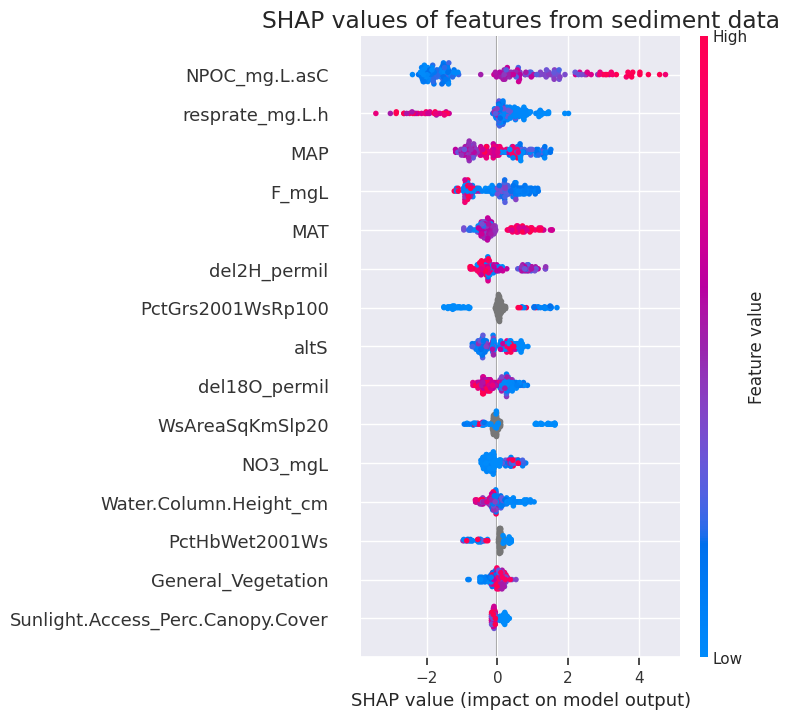

In [23]:
# Plot shapefile values on TRAINING data 

import matplotlib.pyplot as plt
# Ref: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
explainer = shap.TreeExplainer(gb_fitted)
shap_values = explainer.shap_values(X_train)
# generate a beeswarm plot 
plt.title('SHAP values of features from sediment data')
shap_1 = shap.summary_plot(shap_values[1], X_train, show=False)
plt.savefig("SHAP_sed_baseline_trainV2.jpg", dpi=500, bbox_inches='tight') # only can save in png

In [24]:
# Export FORCE PLOT on TRAIN data 
shap.initjs() # necessary to get the interactive graph 
expected_value = explainer.expected_value # expected value arg is necessary for force plot
f=shap.force_plot(explainer.expected_value[1], shap_values[1], X_train)
shap.save_html("shap_forceplot_sed_baseline_trainV2.htm", f)

# 2. Tuned model development: 
Run the analysis on both train and test data. 

In [25]:
# example of bayesian optimization with scikit-optimize
from numpy import mean
from sklearn.model_selection import cross_val_score
from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

In [26]:
# build the pipeline 
from sklearn.pipeline import Pipeline
pipe = Pipeline([('model', HistGradientBoostingClassifier())])

In [27]:
hyperparameter_grid = {
   'learning_rate': [0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.9, 0.10, 0.11, 0.12], # default 0.1 
    'max_depth': [75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 90, 95, 100, 105, 110, 115, 120, None], # default None 
    'min_samples_leaf': [10, 15, 20, 23, 24, 25, 26, 27, 30, 35, 40, 45], # default 20
    'max_leaf_nodes':[10, 15,18, 19, 20, 21, 22, 25, 30, 31, 35, 40, 45], # default 31
    'max_iter': [50, 100, 130, 135, 140, 145, 150, 155, 160, 200, 250, 300], # default 100
    'l2_regularization': [0, 0.1, 0.2, 0.001, 0.002, 0.003, 0.0001],
    'early_stopping':['auto', 'True'], 
    'n_iter_no_change': [2,4,6,8,10,12,14] 
}

In [28]:
from skopt import BayesSearchCV
opt = BayesSearchCV(classifier, hyperparameter_grid, n_iter=10, return_train_score=True, cv=10, random_state=42)

In [29]:
with joblib.parallel_backend('dask'):
    opt.fit(X_train, y_train)

In [30]:
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.7644736842105262
test score: 0.6041666666666666


In [31]:
import pandas as pd

def report(results, n_top=3):
  res = pd.DataFrame(results)
  res = res.sort_values(by=['mean_test_score'], ascending=False, axis=0)
  res.reset_index(inplace = True, drop=True)

  for candidate in range(0, n_top):
    print("Model with rank: {0}".format(candidate))
    print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
          res['mean_test_score'][candidate],
          res['std_test_score'][candidate]))
    print("Parameters: {0}".format(res['params'][candidate]))
    print("") 

In [32]:
report(opt.cv_results_)

Model with rank: 0
Mean validation score: 0.764 (std: 0.063)
Parameters: OrderedDict([('early_stopping', 'auto'), ('l2_regularization', 0.2), ('learning_rate', 0.01), ('max_depth', 78), ('max_iter', 200), ('max_leaf_nodes', 20), ('min_samples_leaf', 25), ('n_iter_no_change', 8)])

Model with rank: 1
Mean validation score: 0.738 (std: 0.081)
Parameters: OrderedDict([('early_stopping', 'True'), ('l2_regularization', 0.003), ('learning_rate', 0.12), ('max_depth', 81), ('max_iter', 155), ('max_leaf_nodes', 21), ('min_samples_leaf', 24), ('n_iter_no_change', 10)])

Model with rank: 2
Mean validation score: 0.713 (std: 0.076)
Parameters: OrderedDict([('early_stopping', 'auto'), ('l2_regularization', 0.1), ('learning_rate', 0.04), ('max_depth', 120), ('max_iter', 250), ('max_leaf_nodes', 15), ('min_samples_leaf', 20), ('n_iter_no_change', 6)])



In [33]:
# plug in the best hp values from BayesSearchCV 

classifier_tune = HistGradientBoostingClassifier(
    l2_regularization= 0.2,learning_rate=0.01,
    max_depth=78 ,max_iter=200 ,max_leaf_nodes=20,
    min_samples_leaf=25, early_stopping='auto', n_iter_no_change=8) 

# this is to get the CV scores 
scores = cross_val_score(estimator=classifier_tune, X=X_train, y=y_train, cv=10, n_jobs=-1)

# fit the model using selected HPs 
# only fit if satisfied with the CV scores 
gb_tuned = classifier_tune.fit(X_train, y_train) 

print("training time taken: ", round(time.time() - start, 0), "seconds") 
print("CV accuracy scores: %s" % scores) 
print("CV accuracy:%.3f +/- %.3f" % (np.mean(scores), np.std(scores)))

training time taken:  173.0 seconds
CV accuracy scores: [0.75       0.84210526 0.84210526 0.84210526 0.73684211 0.63157895
 0.78947368 0.73684211 0.73684211 0.73684211]
CV accuracy:0.764 +/- 0.063


In [34]:
# this is to get the LC scores 
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=classifier_tune, 
                                                        X=X_train, y=y_train, cv=10, n_jobs=-1, random_state=42,
                                                        scoring='accuracy', train_sizes=np.linspace(0.1, 1, 10))

In [35]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

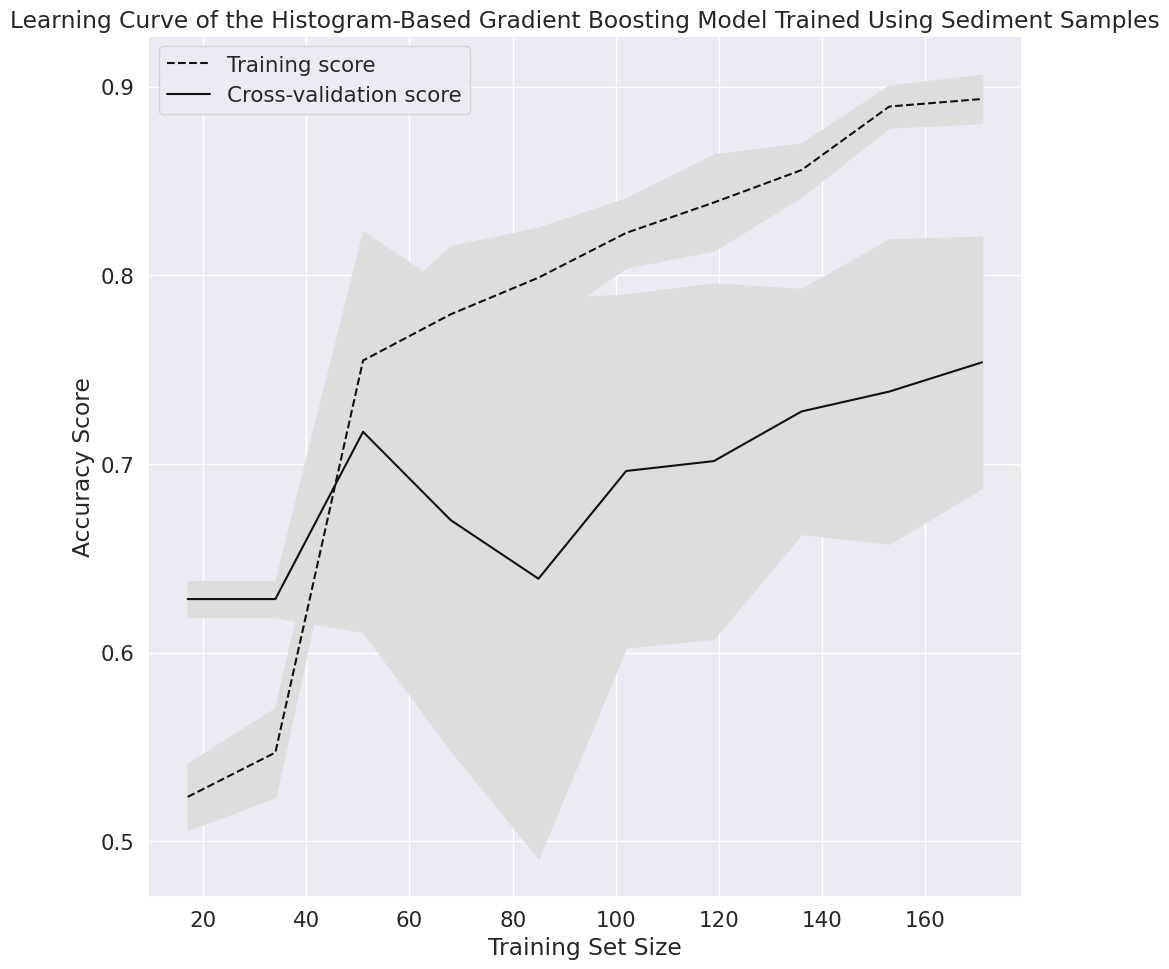

In [36]:
# plot the learning curve
from matplotlib import pyplot as plt
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve of the Histogram-Based Gradient Boosting Model Trained Using Sediment Samples")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig("learningcurveGB_sed_tunedV2.jpg")

In [37]:
# predict test dataset using the tuned dataset 
test_pred = gb_tuned.predict(X_test)
test_pred

#get the accuracy score and confusion matrix from the test set.
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(y_test, test_pred)

0.6041666666666666

In [38]:
print(f"RF train accuracy: {gb_tuned.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {gb_tuned.score(X_test, y_test):.3f}")

RF train accuracy: 0.885
RF test accuracy: 0.604


In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
import pandas as pd
report = classification_report(y_test, test_pred, output_dict=True)
report2 = classification_report(y_test, test_pred)
print(report2) 

# export the csv file 
df = pd.DataFrame(report).transpose()
df.to_csv('classreportGB_sed_tunedV2.csv') 

              precision    recall  f1-score   support

       sed_0       0.57      0.20      0.30        20
       sed_1       0.50      0.50      0.50         2
       sed_2       0.62      0.92      0.74        26

    accuracy                           0.60        48
   macro avg       0.56      0.54      0.51        48
weighted avg       0.59      0.60      0.54        48



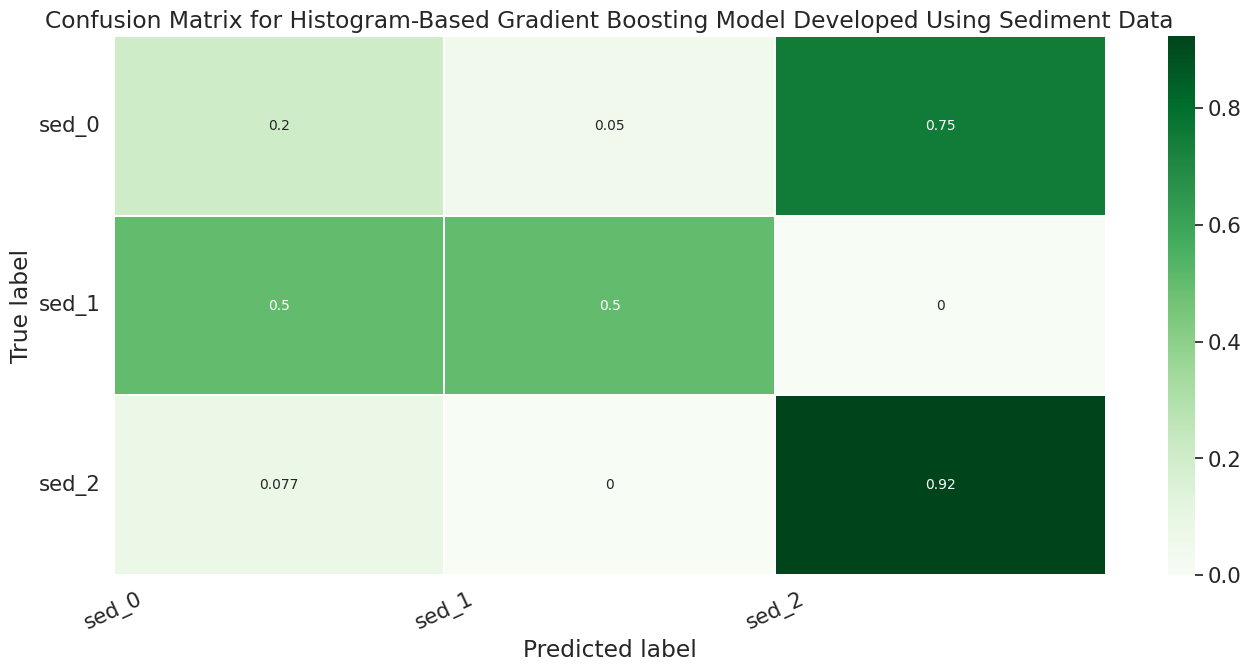

In [40]:
import seaborn as sns
matrix = confusion_matrix(y_test, test_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['sed_0', 'sed_1', 'sed_2']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Histogram-Based Gradient Boosting Model Developed Using Sediment Data')
#plt.show() 
plt.savefig("confusionmatrixGB_sed_tunedV2.jpg", dpi=500, bbox_inches='tight')

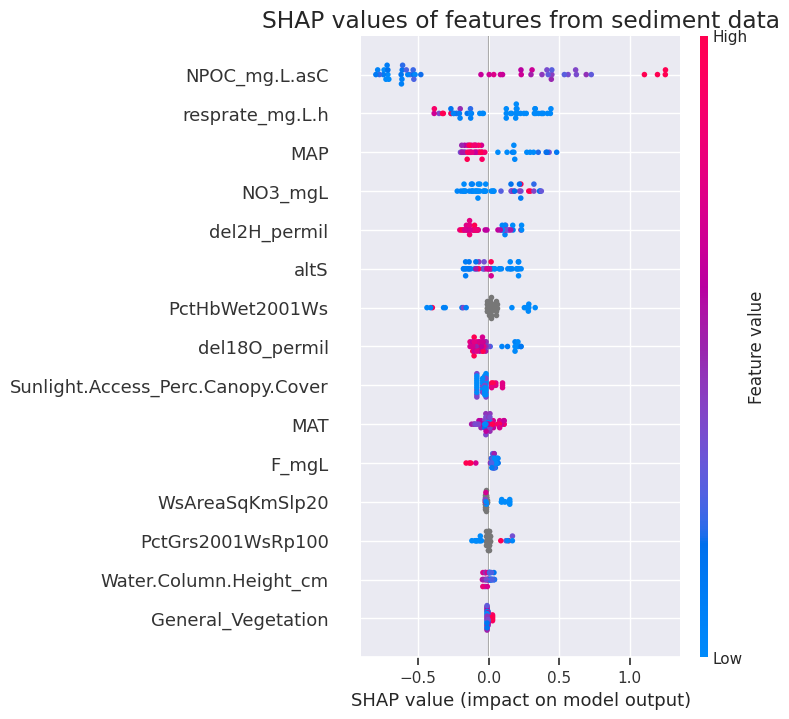

In [41]:
# Plot shap values on TEST data 

import matplotlib.pyplot as plt
# Ref: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
explainer = shap.TreeExplainer(gb_tuned)
shap_values = explainer.shap_values(X_test)
# generate a beeswarm plot 
plt.title('SHAP values of features from sediment data')
shap_1 = shap.summary_plot(shap_values[1], X_test, show=False)
plt.savefig("SHAP_sed_tuned_testV2.jpg", dpi=500, bbox_inches='tight') # only can save in png
 
# prelim interpretation: 
# 1. Top 12 features have the highest variation

In [42]:
# Export FORCE PLOT on TEST data 
shap.initjs() # necessary to get the interactive graph 
expected_value = explainer.expected_value # expected value arg is necessary for force plot
f=shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)
shap.save_html("shap_forceplot_sed_tuned_testV2.htm", f)

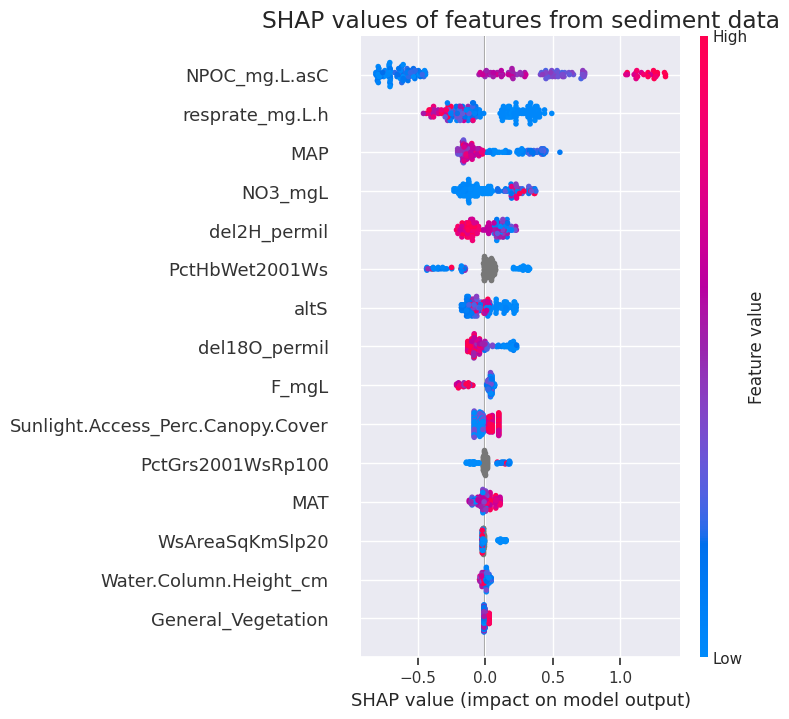

In [43]:
# Plot shapefile values on TRAINING data 

import matplotlib.pyplot as plt
# Ref: https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
explainer = shap.TreeExplainer(gb_tuned)
shap_values = explainer.shap_values(X_train)
# generate a beeswarm plot 
plt.title('SHAP values of features from sediment data')
shap_1 = shap.summary_plot(shap_values[1], X_train, show=False)
plt.savefig("SHAP_sed_tuned_trainV2.jpg", dpi=500, bbox_inches='tight') # only can save in png

In [44]:
# Export FORCE PLOT on TRAIN data 
shap.initjs() # necessary to get the interactive graph 
expected_value = explainer.expected_value # expected value arg is necessary for force plot
f=shap.force_plot(explainer.expected_value[1], shap_values[1], X_train)
shap.save_html("shap_forceplot_sed_tuned_trainV2.htm", f)

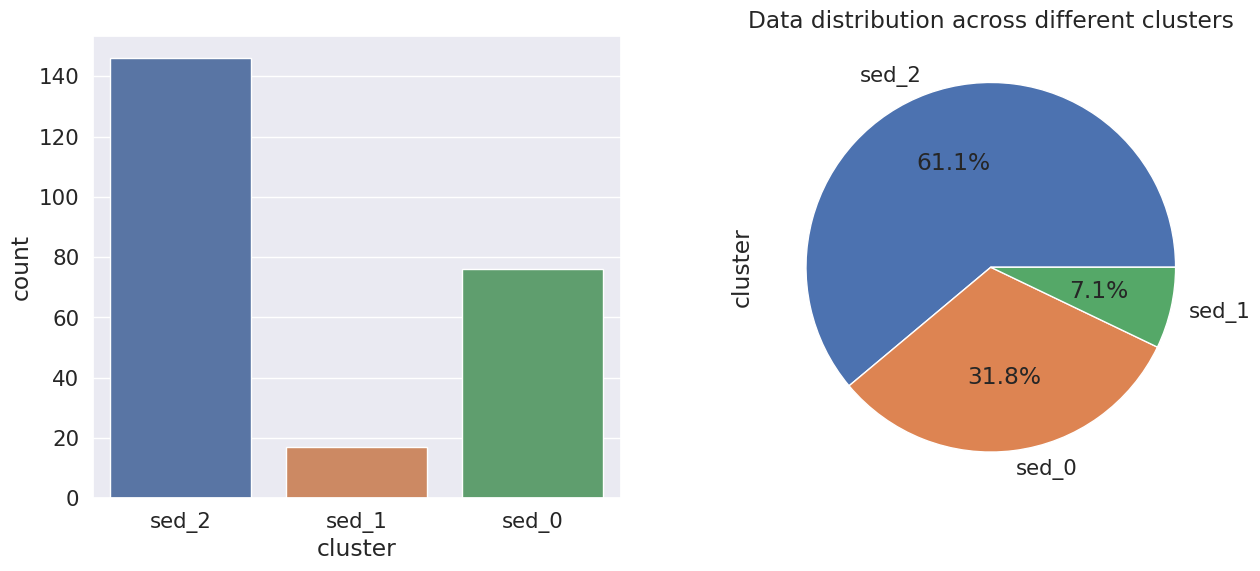

In [45]:
# Lastly print the data distribution across classes 

import seaborn as sns

fig, ax=plt.subplots(1,2,figsize=(15,6))
plt.title('Data distribution across different clusters')
_ = sns.countplot(x='cluster', data=data, ax=ax[0])
_ = data['cluster'].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[1])
plt.savefig("sed_classdistributionV2.jpg", dpi=500, bbox_inches='tight')


# ** End of notebook **¶
The cells following this are for trial purposes only

# Bayesian Optimisation - method 2 
# using Hyperopt implementation

# define the search space. 
# use the same as hp grid 
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.model_selection import StratifiedKFold
# Space
space = {
    'learning_rate': hp.choice('learning_rate', [0.005, 0.01, 0.02, 0.04, 0.06, 0.08, 0.9, 0.10, 0.11, 0.12]),
    'max_depth' : hp.choice('max_depth', [75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 90, 95, 100, 105, 110, 115, 120]),
    'min_samples_leaf' : hp.choice('min_samples_leaf', [10, 15, 20, 23, 24, 25, 26, 27, 30, 35, 40, 45]),
    'max_leaf_nodes' : hp.choice('max_leaf_nodes', [10, 15,18, 19, 20, 21, 22, 25, 30, 31, 35, 40, 45]),     
    'max_iter' : hp.choice('max_iter', [50, 100, 130, 135, 140, 145, 150, 155, 160, 200, 250, 300]), 
    'l2_regularization' : hp.choice('l2_regularization', [0, 0.1, 0.2, 0.001, 0.002, 0.003, 0.0001])
}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# Objective function
def objective(params):
    
    gb_tune = HistGradientBoostingClassifier(**params)
    scores = cross_val_score(gb_tune, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    # Extract the best score
    best_score = max(scores)
    # Loss must be minimized
    accuracy = best_score
    # Dictionary with information for evaluation
    return {'accuracy': accuracy, 'params': params, 'status': STATUS_OK}
# Trials to track progress
bayes_trials = Trials()
# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)

# Print the index of the best parameters
print(best)
# Print the values of the best parameters
print(space_eval(space, best))

# Train model using the best parameters
gb_tune = XGBClassifier(seed=0, 
                           colsample_bytree=0.4, 
                           gamma=0.2, 
                           learning_rate=1, 
                           max_depth=12, 
                           reg_alpha=1e-05,
                           reg_lambda=1
                           ).fit(X_train_transformed,y_train)
# Make prediction using the best model
bayesian_opt_predict = xgboost_bo.predict(X_test_transformed)
# Get predicted probabilities
bayesian_opt_predict_prob = xgboost_bo.predict_proba(X_test_transformed)[:,1]
# Get performance metrics
precision, recall, fscore, support = score(y_test, bayesian_opt_predict)
# Print result
print(f'The recall value for the xgboost Bayesian optimization is {recall[1]:.4f}')

# get the accuracy score and confusion matrix from the test set. 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy_score(y_test, test_pred)

import numpy as np

# Function mapping hyperparameters to a real-valued score
def objective(hyperparameters):
    
    # Machine learning model
    gb = HistGradientBoostingClassifier(**hyperparameters)
    
    # Training 
    # This is very expensive to compute, use dask
    with joblib.parallel_backend('dask'):
        gb_fitted = gb.fit(X_train, y_train)
    
    # Making predictions and evaluating
    predictions = gb.predict(X_train)
    rmse = np.sqrt(np.mean(np.square(predictions - y_valid)))
    
    return rmse

best_accuracy_hgb = gb_fitted.score

print("Best Accuracy of HGB: ", best_accuracy_hgb)  
#print("Best Parameter of HGB:", best_parameter_hgb) 
print("training time taken: ", round(time.time() - start, 0), "seconds")

# define the function used to evaluate a given configuration
@use_named_args(search_space)
def evaluate_model(**params):
	# something
	classifier.set_params(**params)
	# calculate 5-fold cross validation
	result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1, scoring='accuracy')
	# calculate the mean of the scores
	estimate = mean(result)
	return 1.0 - estimate
 
# perform optimization
with joblib.parallel_backend('dask'):
    result = gp_minimize(evaluate_model, search_space)
# summarizing finding:
print('Best Accuracy: %.3f' % (1.0 - result.fun))
print('Best Parameters: n_neighbors=%d, p=%d' % (result.x[0], result.x[1]))

from sklearn.model_selection import RandomizedSearchCV

start = time.time()

parameters_hgb = [{'max_iter': [1000,1200,1600], 
                   'learning_rate': [0.1, 0.2, 0.3], 
                   'max_depth' : [25, 50, 75], 
                   'l2_regularization': [1.5]}] 
grid_search_hgb = RandomizedSearchCV(estimator = classifier, param_distributions=parameters_hgb, 
                               scoring = 'accuracy', cv = 10, n_jobs = 1, verbose=10) # always include verbose param (in +ve integer) to monitor progress
                                # and n_jobs must be a positive number (=1)

    # grid search using dask, import joblib first   
with joblib.parallel_backend('dask'): 
    gb_fitted_tuned = grid_search_hgb.fit(X_train, y_train) 
best_accuracy_hgb = gb_fitted_tuned.best_score_ 
best_parameter_hgb = gb_fitted_tuned.best_params_

print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100)) 
print("Best Parameter of HGB:", best_parameter_hgb)
print("training time taken: ", round(time.time() - start, 0), "seconds")

cv_df = pd.DataFrame(grid_search_hgb.cv_results_).head() 
df.to_csv('tuning_result_sed_tuned.csv')

# fit the tuned parameters 

start = time.time()
#classifier = RandomForestClassifier()
classifier = HistGradientBoostingClassifier(max_iter= 1000, max_depth= 50, learning_rate=0.1, l2_regularization= 1.5) # this can handle NaNs

#rf_fitted = classifier.fit(X_train, y_train)
gb_tuned = classifier.fit(X_train, y_train) 

scores = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=10, n_jobs=-1)

print("training time taken: ", round(time.time() - start, 0), "seconds")
print("CV accuracy scores: %s" % scores)
print("CV accuracy:%.3f +/- %.3f" % (np.mean(scores), np.std(scores))) 

# learning curve for tuned model 
train_sizes, train_scores, test_scores = learning_curve(estimator=gb_tuned, 
                                                        X=X_train, y=y_train, cv=10, n_jobs=-1, 
                                                        scoring='accuracy', train_sizes=np.linspace(0.1, 1, 10))

# get data to plot the learning curve 
from sklearn.model_selection import learning_curve

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plot the learning curve 
from matplotlib import pyplot as plt
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve of the Tuned Histogram-based Gradient Boosting Classification Tree Model Trained Using Sediment Samples")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig("learningcurveGB_sed_tuned.jpg") # prelim interpretation: model overfit; maybe tune the model

Notes: 1. Should you run SHAP on test or train data? Ans: Either one, depending on what do you want to know [1] // 2. Can HGB handle different data types? Ans: Yes, all tree-based model can handle different dtypes [2] 

[1] https://datascience.stackexchange.com/questions/61395/shap-value-analysis-gives-different-feature-importance-on-train-and-test-set 
[2] https://www.quora.com/Decision-Tree-based-models-dont-require-scaling-How-does-scaling-impact-the-predictions-of-decision-tree-based-models 